**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# Data Preparation

In [2]:
from pyts.datasets import make_cylinder_bell_funnel

In [3]:
X, y = make_cylinder_bell_funnel(n_samples=1000, random_state=42)

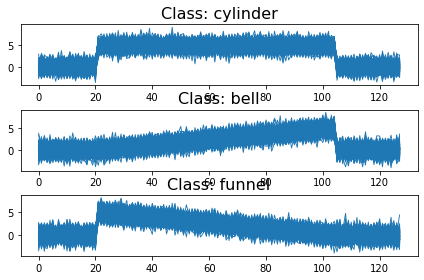

In [4]:
plt.figure()
for i, classe in enumerate(['cylinder', 'bell', 'funnel']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

# Data Normalization

In [5]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

In [6]:
scaler = TimeSeriesScalerMinMax()
X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

# Data Partitioning

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Shaplet Classifier

In [9]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 700
ts_sz 128
n_classes 3
shapelet_sizes {12: 5}


In [10]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

/Users/riccardo/opt/miniconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [11]:
shp_clf.fit(X_train, y_train)

Epoch 1/200
3/3 [==============================] - 0s 5ms/step - loss: 1.1276 - categorical_accuracy: 0.3295 - categorical_crossentropy: 1.0967
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 1.1277 - categorical_accuracy: 0.3241 - categorical_crossentropy: 1.0968
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 1.1274 - categorical_accuracy: 0.3295 - categorical_crossentropy: 1.0965
Epoch 4/200
3/3 [==============================] - 0s 5ms/step - loss: 1.1272 - categorical_accuracy: 0.3310 - categorical_crossentropy: 1.0964
Epoch 5/200
3/3 [==============================] - 0s 5ms/step - loss: 1.1279 - categorical_accuracy: 0.3168 - categorical_crossentropy: 1.0971
Epoch 6/200
3/3 [==============================] - 0s 5ms/step - loss: 1.1275 - categorical_accuracy: 0.3202 - categorical_crossentropy: 1.0968
Epoch 7/200
3/3 [==============================] - 0s 5ms/step - loss: 1.1269 - categorical_accuracy: 0.3300 - categorical_crossentropy:

3/3 [==============================] - 0s 6ms/step - loss: 1.1232 - categorical_accuracy: 0.3398 - categorical_crossentropy: 1.0960
Epoch 114/200
3/3 [==============================] - 0s 5ms/step - loss: 1.1233 - categorical_accuracy: 0.3491 - categorical_crossentropy: 1.0961
Epoch 115/200
3/3 [==============================] - 0s 6ms/step - loss: 1.1232 - categorical_accuracy: 0.3581 - categorical_crossentropy: 1.0961
Epoch 116/200
3/3 [==============================] - 0s 6ms/step - loss: 1.1232 - categorical_accuracy: 0.3722 - categorical_crossentropy: 1.0961
Epoch 117/200
3/3 [==============================] - 0s 5ms/step - loss: 1.1232 - categorical_accuracy: 0.3751 - categorical_crossentropy: 1.0962
Epoch 118/200
3/3 [==============================] - 0s 4ms/step - loss: 1.1231 - categorical_accuracy: 0.3680 - categorical_crossentropy: 1.0961
Epoch 119/200
3/3 [==============================] - 0s 4ms/step - loss: 1.1232 - categorical_accuracy: 0.3744 - categorical_crossentropy:

LearningShapelets(max_iter=200, n_shapelets_per_size={12: 5}, verbose=1,
                  weight_regularizer=0.01)

In [12]:
y_pred = shp_clf.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [13]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.51
F1-score [0.61621622 0.58181818 0.32820513]
              precision    recall  f1-score   support

           0       0.67      0.57      0.62       100
           1       0.53      0.64      0.58       100
           2       0.34      0.32      0.33       100

    accuracy                           0.51       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.51      0.51      0.51       300



# Shaplet-distances-based Classifier

In [14]:
X_train2 = shp_clf.transform(X_train)

3/3 [==============================] - 0s 3ms/step


In [15]:
X_train2.shape

(700, 5)

In [16]:
X_train2

array([[0.0331587 , 0.0106956 , 0.01050229, 0.00733074, 0.00640567],
       [0.03564262, 0.01065683, 0.00392374, 0.00743167, 0.00544429],
       [0.03814507, 0.0153145 , 0.00808844, 0.00853705, 0.01108607],
       ...,
       [0.0242664 , 0.05026506, 0.01195386, 0.01272066, 0.00510796],
       [0.03480439, 0.01279199, 0.00489511, 0.01059381, 0.01048025],
       [0.01619522, 0.00879562, 0.00941893, 0.00824992, 0.01321507]],
      dtype=float32)

In [17]:
X_test2 = shp_clf.transform(X_test)

2/2 [==============================] - 0s 2ms/step


In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train2, y_train)

KNeighborsClassifier()

In [20]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.71
F1-score [0.99497487 0.55837563 0.57843137]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.57      0.55      0.56       100
           2       0.57      0.59      0.58       100

    accuracy                           0.71       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.71      0.71      0.71       300



In [21]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.69
F1-score [0.96969697 0.57798165 0.52173913]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       100
           1       0.53      0.63      0.58       100
           2       0.57      0.48      0.52       100

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



# Feature-based Classifier

In [25]:
import scipy.stats as stats

In [26]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [27]:
X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])

In [28]:
X_train3.shape

(700, 13)

In [29]:
X_train3

array([[ 0.39859446,  0.23519191,  0.05531524, ...,  1.69476262,
         0.36034213, -0.8842845 ],
       [ 0.45011623,  0.21610026,  0.04669932, ...,  2.08290465,
         0.32862626, -0.61767966],
       [ 0.42219464,  0.22458385,  0.05043791, ...,  1.87989759,
         0.27583263, -0.91630096],
       ...,
       [ 0.52655729,  0.28183322,  0.07942997, ...,  1.86832936,
        -0.46340955, -1.14728378],
       [ 0.45154156,  0.22410403,  0.05022261, ...,  2.0148748 ,
         0.19409557, -0.63827757],
       [ 0.44552984,  0.20088531,  0.04035491, ...,  2.21783187,
         0.41476313, -0.20365056]])

In [30]:
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

In [31]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.6733333333333333
F1-score [1.         0.45555556 0.55454545]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.51      0.41      0.46       100
           2       0.51      0.61      0.55       100

    accuracy                           0.67       300
   macro avg       0.67      0.67      0.67       300
weighted avg       0.67      0.67      0.67       300



# Time Series Classifier

In [32]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [33]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9733333333333334
F1-score [0.95918367 0.99       0.97058824]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       100
           1       0.99      0.99      0.99       100
           2       0.95      0.99      0.97       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [34]:
from pyts.classification import KNeighborsClassifier

In [35]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



# CNN Classifier

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization

In [37]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [38]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  128
N. LABELS:  3


In [39]:
cnn = build_simple_cnn(n_timesteps, n_outputs)

In [40]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 121, 16)           144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 121, 16)           64        
_________________________________________________________________
activation_1 (Activation)    (None, 121, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 121, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 117, 32)           2592      
_________________________________________________________________
batch_normalization_2 (Batch (None, 117, 32)           128       
_________________________________________________________________
activation_2 (Activation)    (None, 117, 32)          

In [49]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [42]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

In [43]:
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Train on 560 samples, validate on 140 samples
Epoch 1/5
560/560 [==============================] - 1s 2ms/step - loss: 0.9407 - accuracy: 0.6089 - val_loss: 1.0650 - val_accuracy: 0.3357
Epoch 2/5
560/560 [==============================] - 0s 457us/step - loss: 0.7007 - accuracy: 0.8750 - val_loss: 1.0346 - val_accuracy: 0.3643
Epoch 3/5
560/560 [==============================] - 0s 490us/step - loss: 0.5671 - accuracy: 0.9179 - val_loss: 1.0371 - val_accuracy: 0.5929
Epoch 4/5
560/560 [==============================] - 0s 464us/step - loss: 0.4895 - accuracy: 0.9393 - val_loss: 1.0501 - val_accuracy: 0.4214
Epoch 5/5
560/560 [==============================] - 0s 463us/step - loss: 0.4054 - accuracy: 0.9536 - val_loss: 1.0500 - val_accuracy: 0.3357


In [44]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.34
F1-score [0.         0.50890585 0.03738318]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.34      1.00      0.51       100
           2       0.29      0.02      0.04       100

    accuracy                           0.34       300
   macro avg       0.21      0.34      0.18       300
weighted avg       0.21      0.34      0.18       300



/Users/riccardo/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
cnn.evaluate(X_test_cnn, y_test)

300/300 [==============================] - 0s 90us/step


[1.0486841090520223, 0.3400000035762787]

# LSTM Classifier

In [9]:
from keras.layers import LSTM

In [47]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [48]:
lstm = build_lstm(n_timesteps, n_outputs)

In [49]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 280,835
Trainable params: 280,835
Non-trainable params: 0
_________________________________________________________________


In [50]:
history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Train on 560 samples, validate on 140 samples
Epoch 1/10
560/560 [==============================] - 0s 494us/step - loss: 0.3096 - accuracy: 0.9786 - val_loss: 1.0019 - val_accuracy: 0.4786
Epoch 2/10
560/560 [==============================] - 0s 483us/step - loss: 0.2031 - accuracy: 0.9982 - val_loss: 0.9529 - val_accuracy: 0.4857
Epoch 3/10
560/560 [==============================] - 0s 477us/step - loss: 0.1474 - accuracy: 0.9946 - val_loss: 0.8271 - val_accuracy: 0.8286
Epoch 4/10
560/560 [==============================] - 0s 481us/step - loss: 0.1153 - accuracy: 0.9964 - val_loss: 0.6623 - val_accuracy: 0.9643
Epoch 5/10
560/560 [==============================] - 0s 476us/step - loss: 0.0897 - accuracy: 0.9946 - val_loss: 0.5490 - val_accuracy: 0.9571
Epoch 6/10
560/560 [==============================] - 0s 449us/step - loss: 0.0679 - accuracy: 0.9964 - val_loss: 0.3763 - val_accuracy: 1.0000
Epoch 7/10
560/560 [==============================] - 0s 468us/step - loss: 0.0645 - accur

In [51]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.3333333333333333
F1-score [0.  0.5 0. ]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.33      1.00      0.50       100
           2       0.00      0.00      0.00       100

    accuracy                           0.33       300
   macro avg       0.11      0.33      0.17       300
weighted avg       0.11      0.33      0.17       300



In [52]:
lstm.evaluate(X_test_cnn, y_test)

300/300 [==============================] - 0s 1ms/step


[1.0984290631612141, 0.3333333432674408]

# Multivariate Time Series Classifiers

In [4]:
from pyts.datasets import load_basic_motions

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [5]:
X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)
X_train.shape

(40, 6, 100)

In [6]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
y_train.shape

(40,)

In [8]:
y_train

array([b'Standing', b'Standing', b'Standing', b'Standing', b'Standing',
       b'Standing', b'Standing', b'Standing', b'Standing', b'Standing',
       b'Running', b'Running', b'Running', b'Running', b'Running',
       b'Running', b'Running', b'Running', b'Running', b'Running',
       b'Walking', b'Walking', b'Walking', b'Walking', b'Walking',
       b'Walking', b'Walking', b'Walking', b'Walking', b'Walking',
       b'Badminton', b'Badminton', b'Badminton', b'Badminton',
       b'Badminton', b'Badminton', b'Badminton', b'Badminton',
       b'Badminton', b'Badminton'], dtype='|S12')

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [11]:
X_train = X_train.reshape(40, 100, 6)
X_test = X_test.reshape(40, 100, 6)

In [12]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_train)), X_train.shape[2] 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)
print("N. FEATURES: ", n_features)

TIMESTEPS:  100
N. LABELS:  4
N. FEATURES:  6


In [13]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [54]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [25]:
def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [26]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

In [27]:
lstm2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 4)            176       
_________________________________________________________________
batch_normalization_23 (Batc (None, 100, 4)            16        
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 100, 4)            0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 100, 4)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 4)            144       
_________________________________________________________________
batch_normalization_24 (Batc (None, 100, 4)            16        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 100, 4)           

In [28]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [29]:
history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

Train on 32 samples, validate on 8 samples
Epoch 1/50
32/32 [==============================] - 4s 120ms/step - loss: 1.6396 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 2/50
32/32 [==============================] - 1s 30ms/step - loss: 1.3807 - accuracy: 0.4062 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/50
32/32 [==============================] - 1s 32ms/step - loss: 1.4749 - accuracy: 0.2188 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/50
32/32 [==============================] - 1s 34ms/step - loss: 1.4223 - accuracy: 0.2188 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 5/50
32/32 [==============================] - 1s 33ms/step - loss: 1.3451 - accuracy: 0.4062 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 6/50
32/32 [==============================] - 1s 32ms/step - loss: 1.4631 - accuracy: 0.2500 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 7/50
32/32 [==============================] - 1s 34ms/step - loss: 1.4985 - accuracy: 0.2188 - val_loss:

In [30]:
y_pred = np.argmax(lstm2.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.25
F1-score [0.  0.  0.  0.4]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.25      1.00      0.40        10

    accuracy                           0.25        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.06      0.25      0.10        40



/Users/riccardo/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
X_train_cnn.shape

(32, 100, 6)

In [35]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train_cnn2.shape

(32, 100, 6, 1)

In [37]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [41]:
cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

In [42]:
cnn2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 6, 3)         30        
_________________________________________________________________
batch_normalization_31 (Batc (None, 100, 6, 3)         12        
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 100, 6, 3)         0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 100, 6, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 6, 4)         196       
_________________________________________________________________
batch_normalization_32 (Batc (None, 100, 6, 4)         16        
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 100, 6, 4)        

In [43]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [45]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

Train on 32 samples, validate on 8 samples
Epoch 1/50
32/32 [==============================] - 2s 74ms/step - loss: 1.8272 - accuracy: 0.1562 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 1.6504 - accuracy: 0.3438 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 1.6615 - accuracy: 0.2812 - val_loss: 1.3865 - val_accuracy: 0.2500
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 1.7045 - accuracy: 0.2812 - val_loss: 1.3867 - val_accuracy: 0.2500
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 2.1631 - accuracy: 0.1875 - val_loss: 1.3868 - val_accuracy: 0.2500
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 1.6088 - accuracy: 0.2188 - val_loss: 1.3869 - val_accuracy: 0.2500
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 1.7161 - accuracy: 0.2812 - val_loss: 1.3872

In [47]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4
F1-score [0.45454545 0.         0.75       0.        ]
              precision    recall  f1-score   support

           0       0.29      1.00      0.45        10
           1       0.00      0.00      0.00        10
           2       1.00      0.60      0.75        10
           3       0.00      0.00      0.00        10

    accuracy                           0.40        40
   macro avg       0.32      0.40      0.30        40
weighted avg       0.32      0.40      0.30        40



In [51]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [56]:
cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

In [58]:
cnn3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 93, 16)            784       
_________________________________________________________________
batch_normalization_48 (Batc (None, 93, 16)            64        
_________________________________________________________________
activation_7 (Activation)    (None, 93, 16)            0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 93, 16)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 89, 32)            2592      
_________________________________________________________________
batch_normalization_49 (Batc (None, 89, 32)            128       
_________________________________________________________________
activation_8 (Activation)    (None, 89, 32)           

In [59]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [60]:
history_cnn3 = cnn3.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Train on 32 samples, validate on 8 samples
Epoch 1/50
32/32 [==============================] - 1s 39ms/step - loss: 1.4343 - accuracy: 0.2500 - val_loss: 1.3885 - val_accuracy: 0.2500
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 1.3860 - accuracy: 0.2812 - val_loss: 1.3847 - val_accuracy: 0.2500
Epoch 3/50
32/32 [==============================] - 0s 1ms/step - loss: 1.3422 - accuracy: 0.2812 - val_loss: 1.3822 - val_accuracy: 0.2500
Epoch 4/50
32/32 [==============================] - 0s 1ms/step - loss: 1.3020 - accuracy: 0.4062 - val_loss: 1.3811 - val_accuracy: 0.2500
Epoch 5/50
32/32 [==============================] - 0s 1ms/step - loss: 1.2780 - accuracy: 0.4375 - val_loss: 1.3802 - val_accuracy: 0.5000
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 1.2428 - accuracy: 0.4375 - val_loss: 1.3804 - val_accuracy: 0.5000
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 1.2198 - accuracy: 0.4688 - val_loss: 1.3798

In [61]:
y_pred = np.argmax(cnn3.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.75
F1-score [0.57142857 0.76190476 0.72727273 0.86956522]
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.73      0.80      0.76        10
           2       0.67      0.80      0.73        10
           3       0.77      1.00      0.87        10

    accuracy                           0.75        40
   macro avg       0.79      0.75      0.73        40
weighted avg       0.79      0.75      0.73        40



https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://pyts.readthedocs.io/en/stable/generated/pyts.multivariate.classification.MultivariateClassifier.html#pyts.multivariate.classification.MultivariateClassifier